# Loading pretrained word embeddings

Source: https://github.com/facebookresearch/MUSE/blob/main/demo.ipynb

In [2]:
import io
import numpy as np
import os

In [3]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [48]:
src_path = '../models/classification/FastText/aligned_embeddings/pretrained/wiki.multi.fr.txt'
tgt_path = '../models/classification/FastText/aligned_embeddings/pretrained/wiki.multi.de.txt'
nmax = 200000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path)

# Get nearest neighbors

In [49]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

In [50]:
# printing nearest neighbors in the source space
src_word = 'compositeur'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "compositeur":
1.0000 - compositeur
0.8195 - musicien
0.7617 - musicologue
0.7465 - arrangeur
0.7352 - pianiste


In [51]:
# printing nearest neighbors in the target space
src_word = 'compositeur'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "compositeur":
0.8239 - komponist
0.7302 - filmkomponist
0.7233 - pianist
0.7157 - musikpädagoge
0.7109 - musikwissenschaftler


# Visualize multilingual embeddings

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.06


In [53]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

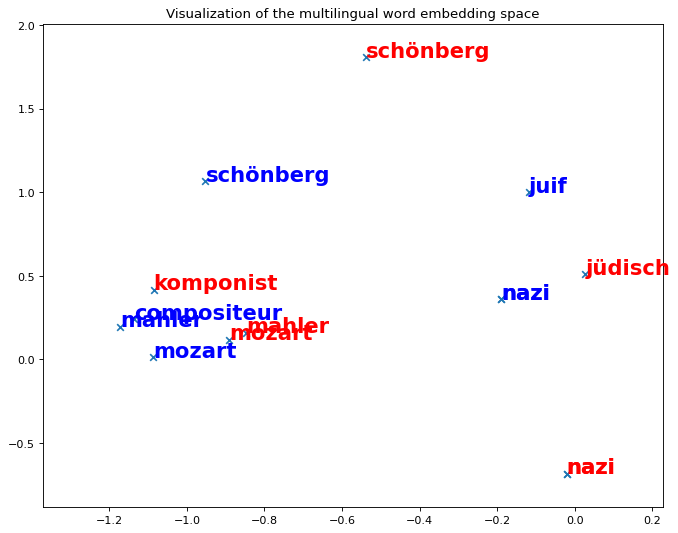

In [55]:
# get 5 random input words
src_words = ['compositeur', 'juif', 'mahler', 'schönberg', 'nazi', 'mozart', 'nazi']
tgt_words = ['komponist', 'jüdisch', 'mahler', 'schönberg', 'nazi', 'mozart', 'nazi']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

#help :coordinates correspond to coefficients for the 2-dimension PCA reduction they run in the notebook